# IMPORT PACKAGES

In [ ]:
!python --version

Python 3.10.12


In [ ]:
# Install packages for compatibility with the autograder
!pip install tensorflow==2.8.0
!pip install keras==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 43.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report

# LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
TRAINING_DIR = "/content/drive/My Drive/RiceLeafDiseaseImages/train/"
TESTING_DIR = "/content/drive/My Drive/RiceLeafDiseaseImages/test/"

# IMAGE AUGMENTATION

In [ ]:
training_datagen = ImageDataGenerator(
        rescale=1. / 255,

        # image augmentation
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',

        # split dataset
        validation_split=0.4
        )

testing_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator=training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(224, 224),
        batch_size=64,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        subset='training'
    )

val_generator =training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(224, 224),
        batch_size=64,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        subset='validation'
    )

test_generator = testing_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(224, 224),
    batch_size=64,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,  # Set shuffle to False for evaluation
)

Found 3082 images belonging to 4 classes.
Found 2052 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


# MODEL BUILDING

In [ ]:
def feature_extractor(inputs):
        feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                                   include_top=False,
                                                                   weights='imagenet')(inputs)
        return feature_extractor

def classifier(inputs):
        x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Dense(128, activation="relu")(x)
        x = tf.keras.layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='linear')(x)

        return x

def final_model(inputs):
        resnet_feature_extractor = feature_extractor(inputs)
        classification_output = classifier(resnet_feature_extractor)
        return classification_output

def define_compile_model():
        inputs = tf.keras.layers.Input(shape=(224,224,3))
        classification_output = final_model(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=classification_output)
        model.compile(optimizer='sgd',
                      loss='squared_hinge',
                      metrics=['accuracy'])
        return model

In [ ]:
model = define_compile_model()

model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272 

# INISIASI CALLBACK

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >0.90 and logs.get('val_accuracy')>0.90):
            print("\nReached >90% accuracy and 90% validation accuracy, Stop training!")
            self.model.stop_training = True

# TRAINING MODEL

In [ ]:
# TRAIN MODEL
EPOCHS = 25
CALLBACK = MyCallback()
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=[CALLBACK])

Epoch 1/25
49/49 [==============================] - 803s 16s/step - loss: 0.4711 - accuracy: 0.7836 - val_loss: 1.0202 - val_accuracy: 0.2412
Epoch 2/25
49/49 [==============================] - 94s 2s/step - loss: 0.1877 - accuracy: 0.9517 - val_loss: 1.7789 - val_accuracy: 0.2710
Epoch 3/25
49/49 [==============================] - 91s 2s/step - loss: 0.1302 - accuracy: 0.9802 - val_loss: 4.5000 - val_accuracy: 0.2417
Epoch 4/25
49/49 [==============================] - 94s 2s/step - loss: 0.1027 - accuracy: 0.9890 - val_loss: 13.5874 - val_accuracy: 0.2417
Epoch 5/25
49/49 [==============================] - 92s 2s/step - loss: 0.0901 - accuracy: 0.9925 - val_loss: 34.1060 - val_accuracy: 0.2417
Epoch 6/25
49/49 [==============================] - 92s 2s/step - loss: 0.0796 - accuracy: 0.9971 - val_loss: 64.2000 - val_accuracy: 0.2417
Epoch 7/25
49/49 [==============================] - 102s 2s/step - loss: 0.0743 - accuracy: 0.9990 - val_loss: 93.4064 - val_accuracy: 0.2442
Epoch 8/25
49

# EVALUASI KINERJA MODEL

In [ ]:
# MODEL EVALUATION
loss, accuracy = model.evaluate(test_generator)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

13/13 [==============================] - 213s 18s/step - loss: 0.1121 - accuracy: 0.9837
Test loss: 0.1121
Test accuracy: 0.9837


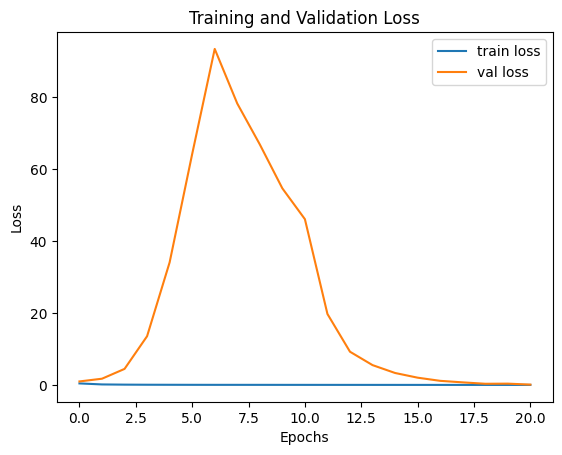

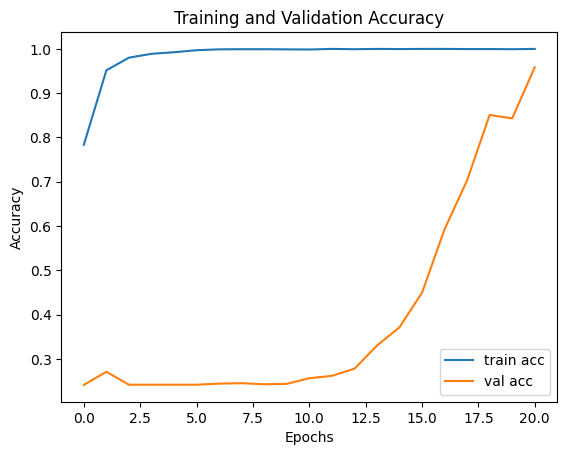

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('LossVal_loss.png')
plt.show()

# Plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('AccVal_acc.png')
plt.show()

In [ ]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps=test_steps_per_epoch)
y_pred = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=class_labels, digits=4))

model.save("model_CS.h5")

Classification Report:
                 precision    recall  f1-score   support

Bacterialblight     1.0000    0.9450    0.9717       200
          Blast     0.9851    0.9950    0.9900       200
      Brownspot     0.9950    0.9950    0.9950       200
         Tungro     0.9569    1.0000    0.9780       200

       accuracy                         0.9838       800
      macro avg     0.9843    0.9838    0.9837       800
   weighted avg     0.9843    0.9838    0.9837       800



[[189   2   1   8]
 [  0 199   0   1]
 [  0   1 199   0]
 [  0   0   0 200]]


<Axes: >

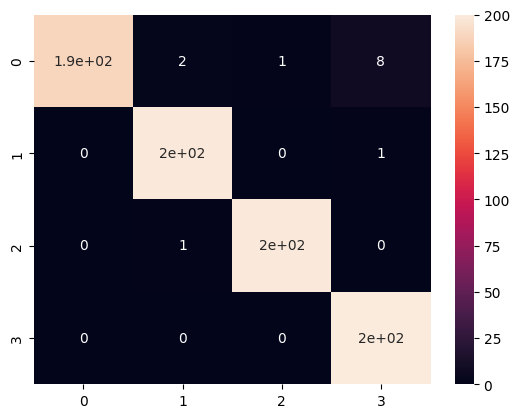

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
sns.heatmap(cm, annot=True)